In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from pprint import pp

from utils import CONFIG

In [46]:
drop_columns = [
    "device",
    "learning_rate",
    "dataset",
    "batch_size",
    "top_k",
    "seed"
]

In [47]:
files = os.listdir("logs")
settings = {}

for fname in files:
    with open(f"logs/{fname}", "r", encoding="utf-8") as fin:
        lines = list(fin)
        epochs, loss, *res = lines[-1].strip().split("\t")

        d = json.loads(lines[0])
        d.pop("datasets")

        d["Epochs"] = int(epochs)
        d["Loss"] = float(loss)

        for i, k in enumerate(CONFIG.top_k):
            precision, recall, ndcg = res[i:i+3]
            d[f"Precision@{k}"] = float(precision)
            d[f"Recall@{k}"] = float(recall)
            d[f"NDCG@{k}"] = float(ndcg)

        settings[fname[:-4]] = d

df = pd.DataFrame(settings).T.convert_dtypes()
df = df.drop(columns=drop_columns)
#df.drop(columns=["model", "fusion"]).sort_index().where(df["n_layers"] > 0).where(df["embedding_dim"] == 1024).where(df["learning_rate"] == 0.001).dropna()
#df[df["n_layers"] > 0]
df

,n_layers,embedding_dim,epochs,model,fusion,multimodal,Epochs,Loss,Precision@5,Recall@5,NDCG@5,Precision@10,Recall@10,NDCG@10,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50
2025-01-09T14:59:39,0,1024,150,ef-mmlgcn,max,True,150,0.0069,0.0805,0.0651,0.097,0.0651,0.097,0.062,0.097,0.062,0.0982,0.062,0.0982,0.0978


In [49]:
df.groupby("n_layers")["Precision@20"].mean()

n_layers
0    0.097
Name: Precision@20, dtype: Float64

In [50]:
file = os.listdir("logs")[-1]
file_path = f"logs/{file}"

with open(file_path, 'r') as f:
    config_line = f.readline().strip()
    config = json.loads(config_line)
    config.pop("datasets")

data = pd.read_csv(file_path, sep='\t', skiprows=1)

In [53]:
data

,Epoch,Loss,Precision@5,Recall@5,NDCG@5,Precision@10,Recall@10,NDCG@10,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50
0,1,0.6923,0.0058,0.0050,0.0070,0.0049,0.0084,0.0076,0.0042,0.0136,0.0098,0.0033,0.0264,0.0143
1,2,0.6699,0.0165,0.0145,0.0209,0.0117,0.0198,0.0205,0.0085,0.0280,0.0237,0.0058,0.0460,0.0302
2,3,0.6488,0.0268,0.0224,0.0337,0.0188,0.0307,0.0324,0.0133,0.0423,0.0369,0.0085,0.0668,0.0456
3,4,0.6241,0.0386,0.0301,0.0468,0.0276,0.0434,0.0451,0.0191,0.0590,0.0509,0.0118,0.0903,0.0622
4,5,0.5941,0.0483,0.0371,0.0584,0.0357,0.0549,0.0571,0.0255,0.0777,0.0659,0.0151,0.1144,0.0791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,0.0071,0.0798,0.0646,0.0958,0.0615,0.0979,0.0969,0.0464,0.1440,0.1152,0.0305,0.2322,0.1471
146,147,0.0073,0.0802,0.0649,0.0964,0.0617,0.0980,0.0972,0.0464,0.1440,0.1154,0.0306,0.2325,0.1474
147,148,0.0070,0.0803,0.0648,0.0969,0.0618,0.0981,0.0977,0.0466,0.1443,0.1161,0.0306,0.2323,0.1479
148,149,0.0073,0.0805,0.0650,0.0971,0.0619,0.0982,0.0978,0.0466,0.1445,0.1162,0.0307,0.2329,0.1481


In [52]:
epochs = data["Epoch"]
loss = data["Loss"]

{'n_layers': 0,
 'device': 'cuda',
 'batch_size': 2048,
 'embedding_dim': 1024,
 'learning_rate': 0.001,
 'dataset': 'dbbook',
 'epochs': 150,
 'model': 'ef-mmlgcn',
 'fusion': 'max',
 'top_k': [5,
           10,
           20,
           50],
 'seed': 19,
 'multimodal': True}

Epoch           150.0000
Loss              0.0069
Precision@5       0.0805
Recall@5          0.0651
NDCG@5            0.0970
Precision@10      0.0620
Recall@10         0.0982
NDCG@10           0.0978
Precision@20      0.0465
Recall@20         0.1445
NDCG@20           0.1161
Precision@50      0.0306
Recall@50         0.2331
NDCG@50           0.1481
Name: 149, dtype: float64


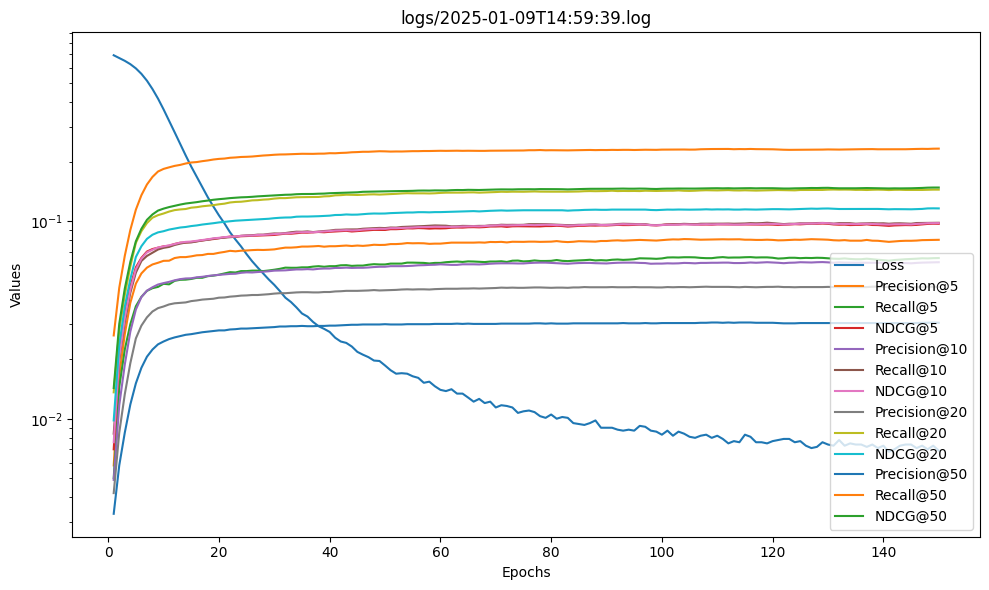

In [56]:
pp(config, width=1)
print()
print(data.iloc[-1])

plt.figure(figsize=(10, 6))

plt.plot(epochs, loss, label="Loss")

for k in CONFIG.top_k:
    plt.plot(epochs, data[f"Precision@{k}"], label=f"Precision@{k}")
    plt.plot(epochs, data[f"Recall@{k}"], label=f"Recall@{k}")
    plt.plot(epochs, data[f"NDCG@{k}"], label=f"NDCG@{k}")


plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title(file_path)
plt.legend()

plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=30))
plt.yscale("log")

plt.tight_layout()
plt.show()